# Retail Credit Risk — German Credit (UCI)
## Probability of Default (PD) Model + Credit Decisioning

This notebook uses the **user-uploaded German Credit dataset** and follows
a **bank-grade credit risk workflow**.

Logical sections:
- eda
- preprocessing
- modeling
- thresholds_decisioning


In [30]:

import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
DATA_PATH = "german_credit_data.csv"


In [31]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/ML/Dev/german.data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

In [32]:
columns = [
    "checking_status",
    "duration_months",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_status",
    "employment_status",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "residence_since",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "existing_credits",
    "job",
    "num_dependents",
    "own_telephone",
    "foreign_worker",
    "credit_risk"   # 1 = good, 2 = bad
]
df = pd.read_csv(f'{dataset_path}',sep=" ",
    header=None,
    names=columns)
print(df.shape)
df.head()


(1000, 21)


,checking_status,duration_months,credit_history,purpose,credit_amount,savings_status,employment_status,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [33]:

df["default"] = (df["credit_risk"] == 2).astype(int)
df["default"].value_counts(normalize=True)


,proportion
default,
0,0.7
1,0.3


In [34]:
print(df.columns)

Index(['checking_status', 'duration_months', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment_status',
       'installment_rate', 'personal_status_sex', 'other_debtors',
       'residence_since', 'property', 'age', 'other_installment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'credit_risk', 'default'],
      dtype='object')


## Feature Preparation

In [35]:

X = df.drop(columns=["credit_risk", "default"])
y = df["default"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_cols, cat_cols


(['duration_months',
  'credit_amount',
  'installment_rate',
  'residence_since',
  'age',
  'existing_credits',
  'num_dependents'],
 ['checking_status',
  'credit_history',
  'purpose',
  'savings_status',
  'employment_status',
  'personal_status_sex',
  'other_debtors',
  'property',
  'other_installment_plans',
  'housing',
  'job',
  'own_telephone',
  'foreign_worker'])

## PD Modeling

In [36]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

model = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

model.fit(X_train, y_train)

SELECTED_THRESHOLD = 0.18

proba = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, proba)
cm = confusion_matrix(y_test, (proba > SELECTED_THRESHOLD).astype(int))


## Confusion matrix

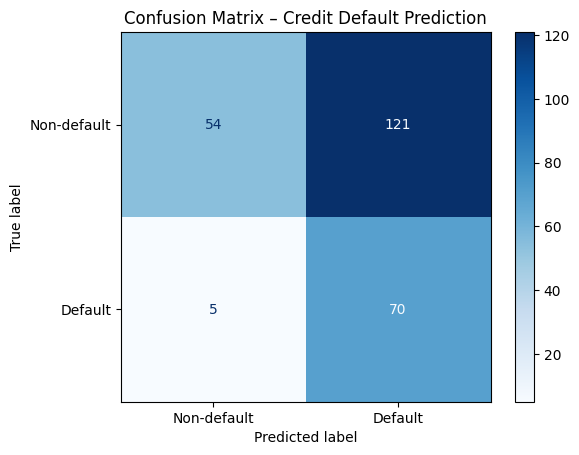

In [37]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-default", "Default"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Credit Default Prediction")
plt.show()

In [38]:
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Non-default", "Actual: Default"],
    columns=["Predicted: Non-default", "Predicted: Default"]
)

cm_df

,Predicted: Non-default,Predicted: Default
Actual: Non-default,54,121
Actual: Default,5,70


## Decisioning

In [39]:

def decision(pd):
    if pd < 0.18:
        return "APPROVE"
    elif pd < 0.28:
        return "REFER"
    else:
        return "DECLINE"

summary = pd.DataFrame({
    "pd": proba,
    "default": y_test.values,
    "decision": pd.Series(proba).apply(decision)
})

summary.groupby("decision").agg(
    count=("default", "size"),
    default_rate=("default", "mean"),
    avg_pd=("pd", "mean")
)


,count,default_rate,avg_pd
decision,,,
APPROVE,59,0.084746,0.091638
DECLINE,152,0.434211,0.633688
REFER,39,0.102564,0.229192
